# Chiron - A Feynman-Enhanced Learning Agent Using LangGraph

## Overview
This notebook presents a structured learning agent implemented using LangGraph. The system guides learners through a sequence of defined but customizable checkpoints, verifying understanding at each step and providing Feynman-style teaching when needed.

## Motivation
In traditional educational settings, access to personalized 1:1 tutoring is often limited by cost and availability. This project aims to democratize personalized learning by creating an AI tutor that can:
- Provide individualized attention and feedback 24/7
- Use your own notes and web-retrieved content as context
- Offer patient, simple explanations of complex topics

## Key Components
1. **Learning State Graph**: Orchestrates the sequential learning workflow
2. **Checkpoint System**: Defines structured learning milestones
3. **Web Search Integration**: Dynamically retrieves relevant learning materials
4. **Context Processing**: Chunks and processes learning materials
5. **Question Generation**: Creates checkpoint-specific verification questions
6. **Understanding Verification**: Evaluates learner comprehension with a clear threshold (70%)
7. **Feynman Teaching**: Simplifies complex concepts when understanding is insufficient

## Method
The system follows a structured learning cycle:

### 1. Checkpoint Definition
- Generates sequential learning milestones with clear success criteria

### 2. Context Building
- Processes student-provided materials or retrieves relevant web content

### 3. Context Validation
- Validates context based on checkpoint criteria
- Performs additional web searches if context doesn't meet checkpoint requirements

### 4. Embedding Storage
- Stores embeddings for retrieving only relevant chunks during verification

### 5. Understanding Verification
- Generates checkpoint-specific questions
- Evaluates responses against a 70% understanding threshold
- Provides detailed feedback

### 6. Progressive Learning
- Advances to the next checkpoint when understanding is verified
- Provides Feynman-style explanations when needed

## Conclusion
This notebook demonstrates a structured approach to guided learning. By combining sequential checkpoints, clear verification thresholds, and Feynman-style teaching, it offers a methodical learning experience with immediate support when needed. The system is particularly effective for complex topics that benefit from step-by-step guidance and simplified explanations.

![Chiron](../images/chiron.svg)

## Requirements

In [1]:
#!pip install langchain-community langchain-openai langgraph pydantic python-dotenv semantic-chunkers semantic-router tavily-python

# Imports

In [2]:
import os
import operator
import uuid
from typing import Annotated, Dict, List, Optional, Tuple, TypedDict

from IPython.display import Image, display
from langchain_community.utils.math import cosine_similarity
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import HumanMessage, SystemMessage
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langgraph.checkpoint.memory import MemorySaver
from langgraph.store.memory import InMemoryStore
from langgraph.graph import END, START, StateGraph
from pydantic import BaseModel, Field
from dotenv import load_dotenv
from semantic_chunkers import StatisticalChunker
from semantic_router.encoders import OpenAIEncoder

# Setup
This agent is implemented using OpenAI's models, but can be used also with self-hosted LLM and embedding models.

In [3]:
load_dotenv()
OpenAI
os.environ["OPENAI_API_KEY"] = os.getenv('OPENAI_API_KEY')
#TavilySearch
os.environ["TAVILY_API_KEY"] = os.getenv('TAVILY_API_KEY')

tavily_search = TavilySearchResults(max_results=3)
llm = ChatOpenAI(model="gpt-4o", temperature=0)
embeddings = OpenAIEmbeddings(model="text-embedding-3-large")

## Data Models Definition
In this section, we define the core data structures for our adaptive learning system using Pydantic models. These models ensure type safety and provide clear structure for:
- Learning goals and objectives
- Checkpoint definitions and tracking
- Search queries for dynamic content
- Verification of learning progress
- Feynman teaching output format
- Question generation

Each model is designed to capture specific aspects of the learning process while maintaining strict type validation.

In [5]:
class Goals(BaseModel):
    """Structure for defining learning goals"""
    goals: str = Field(None, description="Learning goals")

class LearningCheckpoint(BaseModel):
    """Structure for a single checkpoint"""
    description: str = Field(..., description="Main checkpoint description")
    criteria: List[str] = Field(..., description="List of success criteria")
    verification: str = Field(..., description="How to verify this checkpoint")

class Checkpoints(BaseModel):
    """Main checkpoints container with index tracking"""
    checkpoints: List[LearningCheckpoint] = Field(
        ..., 
        description="List of checkpoints covering foundation, application, and mastery levels"
    )

class SearchQuery(BaseModel):
    """Structure for search query collection"""
    search_queries: list = Field(None, description="Search queries for retrieval.")

class LearningVerification(BaseModel):
    """Structure for verification results"""
    understanding_level: float = Field(..., ge=0, le=1)
    feedback: str
    suggestions: List[str]
    context_alignment: bool

class FeynmanTeaching(BaseModel):
    """Structure for Feynman teaching method"""
    simplified_explanation: str
    key_concepts: List[str]
    analogies: List[str]

class QuestionOutput(BaseModel):
    """Structure for question generation output"""
    question: str

class InContext(BaseModel):
    """Structure for context verification"""
    is_in_context: str = Field(..., description="Yes or No")

## Learning State Definition
Here we define the main state for our agent. This state tracks:
- The learning topic and goals
- Context and search results
- Current progress through checkpoints
- Verification results and teaching outputs
- Current question-answer pair

In [6]:
class LearningtState(TypedDict):
    topic: str
    goals: List[Goals]
    context: str
    context_chunks: Annotated[list, operator.add]
    context_key: str
    search_queries: SearchQuery
    checkpoints: Checkpoints
    verifications: LearningVerification
    teachings: FeynmanTeaching
    current_checkpoint: int
    current_question: QuestionOutput
    current_answer: str

## Helper Functions
The system uses three utility functions:

1. `extract_content_from_chunks`: Processes and combines text chunks into coherent content

2. `format_checkpoints_as_message`: Converts checkpoint data into prompt format

3. `generate_checkpoint_message`: Creates formatted message for context retrieval

In [7]:
def extract_content_from_chunks(chunks):
    """Extract and combine content from chunks with splits attribute.
    
    Args:
        chunks: List of chunk objects that may contain splits attribute
        
    Returns:
        str: Combined content from all chunks joined with newlines
    """
    content = []
    
    for chunk in chunks:
        if hasattr(chunk, 'splits') and chunk.splits:
            chunk_content = ' '.join(chunk.splits)
            content.append(chunk_content)
    
    return '\n'.join(content)

def format_checkpoints_as_message(checkpoints: Checkpoints) -> str:
    """Convert Checkpoints object to a formatted string for the message.
    
    Args:
        checkpoints (Checkpoints): Checkpoints object containing learning checkpoints
        
    Returns:
        str: Formatted string containing numbered checkpoints with descriptions and criteria
    """
    message = "Here are the learning checkpoints:\n\n"
    for i, checkpoint in enumerate(checkpoints.checkpoints, 1):
        message += f"Checkpoint {i}:\n"
        message += f"Description: {checkpoint.description}\n"
        message += "Success Criteria:\n"
        for criterion in checkpoint.criteria:
            message += f"- {criterion}\n"
    return message

def generate_checkpoint_message(checks: List[LearningCheckpoint]) -> HumanMessage:
    """Generate a formatted message for learning checkpoints that need context.
    
    Args:
        checks (List[LearningCheckpoint]): List of learning checkpoint objects
        
    Returns:
        HumanMessage: Formatted message containing checkpoint descriptions, criteria and 
                     verification methods, ready for context search
    """
    formatted_checks = []
    
    for check in checks:
        checkpoint_text = f"""
        Description: {check.description}
        Success Criteria:
        {chr(10).join(f'- {criterion}' for criterion in check.criteria)}
        Verification Method: {check.verification}
        """
        formatted_checks.append(checkpoint_text)
    
    all_checks = "\n---\n".join(formatted_checks)
    
    checkpoints_message = HumanMessage(content=f"""The following learning checkpoints need additional context:
        {all_checks}
        
        Please generate search queries to find relevant information.""")
    
    return checkpoints_message

## Prompt Configuration
Here we define the core instruction prompts for our LLM. Each message serves a specific purpose in the learning process:

1. `learning_checkpoints_generator`: Creates structured learning milestones with clear criteria
2. `checkpoint_based_query_generator`: Generates targeted search queries for content retrieval
3. `question_generator`: Creates verification questions aligned with checkpoints
4. `answer_verifier`: Evaluates learner responses against success criteria
5. `feynman_teacher`: Crafts simplified explanations using the Feynman technique

In [8]:
learning_checkpoints_generator = SystemMessage(content="""You will be given a learning topic title and learning objectives.
Your goal is to generate clear learning checkpoints that will help verify understanding and progress through the topic.
The output should be in the following dictionary structure:
checkpoint 
-> description (level checkpoint description)
-> criteria
-> verification (How to verify this checkpoint (Feynman Methods))
Requirements for each checkpoint:
- Description should be clear and concise
- Criteria should be specific and measurable (3-5 items)
- Verification method should be practical and appropriate for the level
- Verification will be checked by language model, so it must by in natural language
- All elements should align with the learning objectives
- Use action verbs and clear language
Ensure all checkpoints progress logically from foundation to mastery.
IMPORTANT - ANSWER ONLY 3 CHECKPOINTS""")

checkpoint_based_query_generator = SystemMessage(content="""You will be given learning checkpoints for a topic.
Your goal is to generate search queries that will retrieve content matching each checkpoint's requirements from retrieval systems or web search.
Follow these steps:
1. Analyze each learning checkpoint carefully
2. For each checkpoint, generate ONE targeted search query that will retrieve:
   - Content for checkpoint verification""")

validate_context = SystemMessage(content="""You will be given a learning criteria and context.
Check if the the criteria could be answered using the context.
Always answer YES or NO""")

question_generator = SystemMessage(content="""You will be given a checkpoint description, success criteria, and verification method.
Your goal is to generate an appropriate question that aligns with the checkpoint's verification requirements.
The question should:
1. Follow the specified verification method
2. Cover all success criteria
3. Encourage demonstration of understanding
4. Be clear and specific
Output should be a single, well-formulated question that effectively tests the checkpoint's learning objectives.""")

answer_verifier = SystemMessage(content="""You will be given a student's answer, question, checkpoint details, and relevant context.
Your goal is to analyze the answer against the checkpoint criteria and provided context.
Analyze considering:
1. Alignment with verification method specified
2. Coverage of all success criteria
3. Use of relevant concepts from context
4. Depth and accuracy of understanding
Output should include:
- understanding_level: float between 0 and 1
- feedback: detailed explanation of the assessment
- suggestions: list of specific improvements
- context_alignment: boolean indicating if the answer aligns with provided context""")

feynman_teacher = SystemMessage(content="""You will be given verification results, checkpoint criteria, and learning context.
Your goal is to create a Feynman-style teaching explanation for concepts that need reinforcement.
The explanation should include:
1. Simplified explanation without technical jargon
2. Concrete, relatable analogies
3. Key concepts to remember
Output should follow the Feynman technique:
- simplified_explanation: clear, jargon-free explanation
- key_concepts: list of essential points
- analogies: list of relevant, concrete comparisons
Focus on making complex ideas accessible and memorable.""")


## Context Storage
The `ContextStore` class manages context chunks and embeddings in memory, optimizing token usage by allowing access to only relevant context during answer verification.

In [9]:
class ContextStore:
    """Store for managing context chunks and their embeddings in memory.
    
    A class that provides storage and retrieval of context data using an in-memory store.
    Each context entry consists of context chunks and their corresponding embeddings.
    """
    
    def __init__(self):
        """Initialize ContextStore with an empty in-memory store."""
        self.store = InMemoryStore()
        
    def save_context(self, context_chunks: list, embeddings: list, key: str = None):
        """Save context chunks and their embeddings to the store.
        
        Args:
            context_chunks (list): List of context chunk objects
            embeddings (list): List of corresponding embeddings for the chunks
            key (str, optional): Custom key for storing the context. Defaults to None,
                               in which case a UUID is generated.
            
        Returns:
            str: The key used to store the context
        """
        namespace = ("context",)
        
        if key is None:
            key = str(uuid.uuid4())
            
        value = {
            "chunks": context_chunks,
            "embeddings": embeddings
        }
        
        self.store.put(namespace, key, value)
        return key
        
    def get_context(self, context_key: str):
        """Retrieve context data from the store using a key.
        
        Args:
            context_key (str): The key used to store the context
            
        Returns:
            dict: The stored context value containing chunks and embeddings
        """
        namespace = ("context",)
        memory = self.store.get(namespace, context_key)
        return memory.value

## Core Learning System Functions
The learning system is powered by eight main functions that process and update the `LearningState`:

### Content Generation and Processing
1. `generate_checkpoints`: Creates learning milestones from topic and goals
2. `generate_query`: Formulates checkpoint-based search queries
3. `search_web`: Retrieves content via Tavilysearch
5. `chunk_context`: Segments learning materials
6. `context_validation`: Ensures context meets checkpoint requirements

### Learning Verification and Support
6. `generate_question`: Creates verification questions
7. `verify_answer`: Evaluates against checkpoint criteria
8. `teach_concept`: Provides Feynman-style explanations

In [10]:
def generate_query(state: LearningtState):
    """Generates search queries based on learning checkpoints from current state."""
    structured_llm = llm.with_structured_output(SearchQuery) 
    checkpoints_message = HumanMessage(content=format_checkpoints_as_message(state['checkpoints']))  
    messages = [checkpoint_based_query_generator, checkpoints_message]
    search_queries = structured_llm.invoke(messages)
    return {"search_queries": search_queries}

def search_web(state: LearningtState):
    """Retrieves and processes web search results based on search queries."""
    search_queries = state["search_queries"].search_queries
    
    all_search_docs = []
    for query in search_queries:
        search_docs = tavily_search.invoke(query)
        all_search_docs.extend(search_docs)
    
    formatted_search_docs = [
        f'Context: {doc["content"]}\n Source: {doc["url"]}\n'
        for doc in all_search_docs
    ]

    chunk_embeddings = embeddings.embed_documents(formatted_search_docs)
    context_key = context_store.save_context(
        formatted_search_docs,
        chunk_embeddings,
        key=state.get('context_key')
    )
    
    return {"context_chunks": formatted_search_docs}

def generate_checkpoints(state: LearningtState):
    """Creates learning checkpoints based on given topic and goals."""
    structured_llm = llm.with_structured_output(Checkpoints)
    messages = [
        learning_checkpoints_generator,
        SystemMessage(content=f"Topic: {state['topic']}"),
        SystemMessage(content=f"Goals: {', '.join(str(goal) for goal in state['goals'])}")
    ]
    checkpoints = structured_llm.invoke(messages)
    return {"checkpoints": checkpoints}

def chunk_context(state: LearningtState):
    """Splits context into manageable chunks and generates their embeddings."""
    encoder = OpenAIEncoder(name="text-embedding-3-large")
    chunker = StatisticalChunker(
        encoder=encoder,
        min_split_tokens=128,
        max_split_tokens=512
    )
    
    chunks = chunker([state['context']])
    content = []
    for chunk in chunks:
        content.append(extract_content_from_chunks(chunk))

    chunk_embeddings = embeddings.embed_documents(content)
    context_key = context_store.save_context(
        content,
        chunk_embeddings,
        key=state.get('context_key')
    )
    return {"context_chunks": content, "context_key": context_key}

def context_validation(state: LearningtState):
    """Validates context coverage against checkpoint criteria using stored embeddings."""
    context = context_store.get_context(state['context_key'])
    chunks = context['chunks']
    chunk_embeddings = context['embeddings']
    
    checks = []
    structured_llm = llm.with_structured_output(InContext)
    
    for checkpoint in state['checkpoints'].checkpoints:
        query = embeddings.embed_query(checkpoint.verification)
        
        similarities = cosine_similarity([query], chunk_embeddings)[0]
        top_3_indices = sorted(range(len(similarities)), 
                             key=lambda i: similarities[i], 
                             reverse=True)[:3]
        relevant_chunks = [chunks[i] for i in top_3_indices]
        
        messages = [
            validate_context,
            HumanMessage(content=f"""
            Criteria:
            {chr(10).join(f"- {c}" for c in checkpoint.criteria)}
            
            Context:
            {chr(10).join(relevant_chunks)}
            """)
        ]
        
        response = structured_llm.invoke(messages)
        if response.is_in_context.lower() == "no":
            checks.append(checkpoint)
    
    if checks:
        structured_llm = llm.with_structured_output(SearchQuery)
        checkpoints_message = generate_checkpoint_message(checks)
        
        messages = [checkpoint_based_query_generator, checkpoints_message]
        search_queries = structured_llm.invoke(messages)
        return {"search_queries": search_queries}
    
    return {"search_queries": None}

def generate_question(state: LearningtState):
    """Generates assessment questions based on current checkpoint verification requirements."""
    structured_llm = llm.with_structured_output(QuestionOutput)
    current_checkpoint = state['current_checkpoint']
    checkpoint_info = state['checkpoints'].checkpoints[current_checkpoint]
    
    messages = [
        question_generator,
        HumanMessage(content=f"""
        Checkpoint Description: {checkpoint_info.description}
        Success Criteria:
        {chr(10).join(f"- {c}" for c in checkpoint_info.criteria)}
        Verification Method: {checkpoint_info.verification}
        
        Generate an appropriate verification question.""")
    ]
    
    question_output = structured_llm.invoke(messages)
    return {"current_question": question_output.question}

def verify_answer(state: LearningtState):
    """Evaluates user answers against checkpoint criteria using relevant context chunks."""
    structured_llm = llm.with_structured_output(LearningVerification)
    current_checkpoint = state['current_checkpoint']
    checkpoint_info = state['checkpoints'].checkpoints[current_checkpoint]
    
    context = context_store.get_context(state['context_key'])
    chunks = context['chunks']
    chunk_embeddings = context['embeddings']
    
    query = embeddings.embed_query(checkpoint_info.verification)
    
    similarities = cosine_similarity([query], chunk_embeddings)[0]
    top_3_indices = sorted(range(len(similarities)), 
                         key=lambda i: similarities[i], 
                         reverse=True)[:3]
    relevant_chunks = [chunks[i] for i in top_3_indices]
    
    messages = [
        answer_verifier,
        HumanMessage(content=f"""
        Question: {state['current_question']}
        Answer: {state['current_answer']}
        
        Checkpoint Description: {checkpoint_info.description}
        Success Criteria:
        {chr(10).join(f"- {c}" for c in checkpoint_info.criteria)}
        Verification Method: {checkpoint_info.verification}
        
        Context:
        {chr(10).join(relevant_chunks)}
        
        Assess the answer.""")
    ]
    
    verification = structured_llm.invoke(messages)
    return {"verifications": verification}
    
def teach_concept(state: LearningtState):
    """Creates simplified Feynman-style explanations for concepts that need reinforcement."""
    structured_llm = llm.with_structured_output(FeynmanTeaching)
    current_checkpoint = state['current_checkpoint']
    checkpoint_info = state['checkpoints'].checkpoints[current_checkpoint]
    
    messages = [
        feynman_teacher,
        HumanMessage(content=f"""
        Criteria: {checkpoint_info.criteria}
        Verification: {state['verifications']}
        
        Context:
        {state['context_chunks']}
        
        Create a Feynman teaching explanation.""")
    ]
    
    teaching = structured_llm.invoke(messages)
    return {"teachings": teaching}

## Helper State Management Functions
Here we define two auxiliary functions that manage the learning flow:

1. `user_answer`: Placeholder for collecting user responses to verification questions
2. `next_checkpoint`: Increments the checkpoint counter to progress through learning milestones

In [11]:
def user_answer(state: LearningtState):
    """Placeholder for handling user's answer input."""
    pass

def next_checkpoint(state: LearningtState):
    """Advances to the next checkpoint in the learning sequence."""
    current_checkpoint = state['current_checkpoint'] + 1
    return {'current_checkpoint': current_checkpoint}

## Routing Logic Functions
Four routing functions control the agent's workflow:

1. `route_context`: Manages context processing vs. query generation
2. `route_verification`: Directs flow based on understanding level (70% threshold)
3. `route_teaching`: Handles post-teaching progression
4. `route_search`: Back to search if context is irrelevant

In [12]:
def route_context(state: LearningtState):
    """Determines whether to process existing context or generate new search queries."""
    if state.get("context"):
        return 'chunk_context'
    return 'generate_query'

def route_verification(state: LearningtState):
    """Determines next step based on verification results and checkpoint progress."""
    current_checkpoint = state['current_checkpoint']
    
    if state['verifications'].understanding_level < 0.7:
        return 'teach_concept'
        
    if current_checkpoint + 1 < len(state['checkpoints'].checkpoints):
        return 'next_checkpoint'
    
    return END

def route_teaching(state: LearningtState):
    """Routes to next checkpoint or ends session after teaching intervention."""
    current_checkpoint = state['current_checkpoint']
    if current_checkpoint + 1 < len(state['checkpoints'].checkpoints):
        return 'next_checkpoint'
    return END

def route_search(state: LearningtState):
    """Directs flow between question generation and web search based on query status."""
    if state['search_queries'] is None:
        return "generate_question"
    return "search_web"

## Building the Learning Flow Graph
Here we construct the complete graph structure for our adaptive learning system using LangGraph. The graph defines:

1. **Node Setup**
  - Core processing nodes (generate_query, search_web, chunk_context, context_validation)
  - Learning management nodes (generate_checkpoints, generate_question)
  - Interactive nodes (user_answer)
  - Evaluation nodes (verify_answer, teach_concept)

2. **Flow Definition**
  - Starting point (generate_checkpoints)
  - Conditional paths based on context availability and verification results
  - Interactive breaks for user input

3. **Graph Configuration**
  - Uses MemorySaver for persistence
  - Uses ContextStore to keep embeddings
  - Includes human in the loop strategy

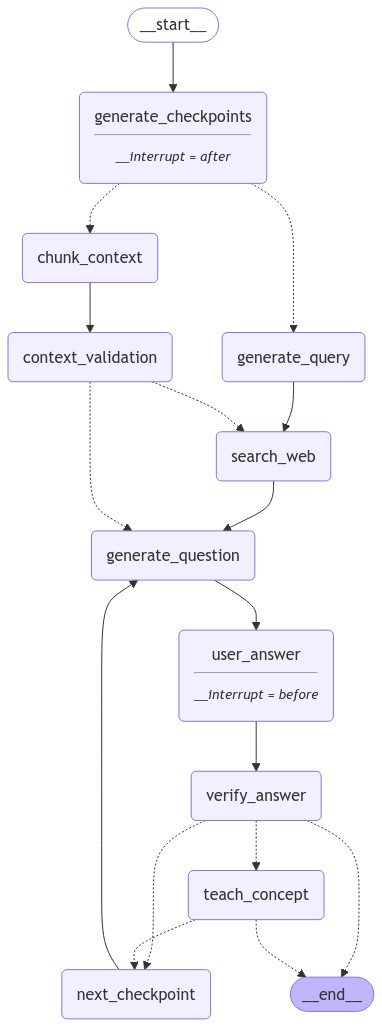

In [13]:
searcher = StateGraph(LearningtState)
memory = MemorySaver()
context_store = ContextStore()

searcher.add_node("generate_query", generate_query)
searcher.add_node("search_web", search_web)
searcher.add_node("chunk_context", chunk_context)
searcher.add_node("context_validation", context_validation)
searcher.add_node("generate_checkpoints", generate_checkpoints)
searcher.add_node("generate_question", generate_question)
searcher.add_node("next_checkpoint", next_checkpoint)
searcher.add_node("user_answer", user_answer)
searcher.add_node("verify_answer", verify_answer)
searcher.add_node("teach_concept", teach_concept)

# Flow
searcher.add_edge(START, "generate_checkpoints")
searcher.add_conditional_edges('generate_checkpoints', route_context,['chunk_context', 'generate_query'])
searcher.add_edge("generate_query", "search_web")
searcher.add_edge("search_web", "generate_question")
searcher.add_edge("chunk_context", 'context_validation')
searcher.add_conditional_edges('context_validation', route_search,['search_web', 'generate_question'])

searcher.add_edge("generate_question", "user_answer")
searcher.add_edge("user_answer", "verify_answer")
searcher.add_conditional_edges(
    "verify_answer",
    route_verification,
    {
        "next_checkpoint": "next_checkpoint",
        "teach_concept": "teach_concept",
        END: END
    }
)

searcher.add_conditional_edges(
    "teach_concept",
    route_teaching,
    {
        "next_checkpoint": "next_checkpoint",
        END: END
    }
)
searcher.add_edge("next_checkpoint", "generate_question")



graph = searcher.compile(interrupt_after=["generate_checkpoints"], interrupt_before=["user_answer"], checkpointer=memory)

display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

# Agent Use Case - Learn Anemia from own note

## Pretty print helper functions

Helper functions to improve output readability and example visibility:

In [14]:
def print_checkpoints(event):
    """Pretty print checkpoints information with improved visual formatting"""
    checkpoints = event.get('checkpoints', '')
    if checkpoints:
        print("\n" + "=" * 80)
        print("🎯 LEARNING CHECKPOINTS OVERVIEW".center(80))
        print("=" * 80 + "\n")
        
        for i, checkpoint in enumerate(checkpoints.checkpoints, 1):
            # Checkpoint header with number
            print(f"📍 CHECKPOINT #{i}".center(80))
            print("─" * 80 + "\n")
            
            # Description section with text wrapping
            print("📝 Description:")
            print("─" * 40)
            words = checkpoint.description.split()
            current_line = []
            current_length = 0
            
            for word in words:
                if current_length + len(word) + 1 <= 70:
                    current_line.append(word)
                    current_length += len(word) + 1
                else:
                    print(f"  {' '.join(current_line)}")
                    current_line = [word]
                    current_length = len(word)
            
            if current_line:
                print(f"  {' '.join(current_line)}")
            print()
            
            # Success Criteria section
            print("✅ Success Criteria:")
            print("─" * 40)
            for j, criterion in enumerate(checkpoint.criteria, 1):
                # Wrap each criterion text
                words = criterion.split()
                current_line = []
                current_length = 0
                first_line = True
                
                for word in words:
                    if current_length + len(word) + 1 <= 66:  # Shorter width to account for numbering
                        current_line.append(word)
                        current_length += len(word) + 1
                    else:
                        if first_line:
                            print(f"  {j}. {' '.join(current_line)}")
                            first_line = False
                        else:
                            print(f"     {' '.join(current_line)}")
                        current_line = [word]
                        current_length = len(word)
                
                if current_line:
                    if first_line:
                        print(f"  {j}. {' '.join(current_line)}")
                    else:
                        print(f"     {' '.join(current_line)}")
            print()
            
            # Verification Method section
            print("🔍 Verification Method:")
            print("─" * 40)
            words = checkpoint.verification.split()
            current_line = []
            current_length = 0
            
            for word in words:
                if current_length + len(word) + 1 <= 70:
                    current_line.append(word)
                    current_length += len(word) + 1
                else:
                    print(f"  {' '.join(current_line)}")
                    current_line = [word]
                    current_length = len(word)
            
            if current_line:
                print(f"  {' '.join(current_line)}")
            print()
            
            # Separator between checkpoints
            if i < len(checkpoints.checkpoints):
                print("~" * 80 + "\n")
        
        print("=" * 80 + "\n")

def print_verification_results(event):
    """Pretty print verification results with improved formatting"""
    verifications = event.get('verifications', '')
    if verifications:
        print("\n" + "=" * 50)
        print("📊 VERIFICATION RESULTS".center(50))
        print("=" * 50 + "\n")

        # Understanding Level with visual bar
        understanding = verifications.understanding_level
        bar_length = 20
        filled_length = int(understanding * bar_length)
        bar = "█" * filled_length + "░" * (bar_length - filled_length)
        
        print(f"📈 Understanding Level: [{bar}] {understanding * 100:.1f}%\n")
        
        # Feedback section
        print("💡 Feedback:")
        print(f"{verifications.feedback}\n")
        
        # Suggestions section
        print("🎯 Suggestions:")
        for i, suggestion in enumerate(verifications.suggestions, 1):
            print(f"  {i}. {suggestion}")
        print()
        
        # Context Alignment
        print("🔍 Context Alignment:")
        print(f"{verifications.context_alignment}\n")
        
        print("-" * 50 + "\n")
def print_teaching_results(event):
    """Pretty print Feynman teaching results with improved formatting"""
    teachings = event.get('teachings', '')
    if teachings:
        print("\n" + "=" * 70)
        print("🎓 FEYNMAN TEACHING EXPLANATION".center(70))
        print("=" * 70 + "\n")

        # Simplified Explanation section
        print("📚 SIMPLIFIED EXPLANATION:")
        print("─" * 30)
        # Split explanation into paragraphs for better readability
        paragraphs = teachings.simplified_explanation.split('\n')
        for paragraph in paragraphs:
            # Wrap text at 60 characters for better readability
            words = paragraph.split()
            lines = []
            current_line = []
            current_length = 0
            
            for word in words:
                if current_length + len(word) + 1 <= 60:
                    current_line.append(word)
                    current_length += len(word) + 1
                else:
                    lines.append(' '.join(current_line))
                    current_line = [word]
                    current_length = len(word)
            
            if current_line:
                lines.append(' '.join(current_line))
            
            for line in lines:
                print(f"{line}")
            print()
        
        # Key Concepts section
        print("💡 KEY CONCEPTS:")
        print("─" * 30)
        for i, concept in enumerate(teachings.key_concepts, 1):
            print(f"  {i}. {concept}")
        print()
        
        # Analogies section
        print("🔄 ANALOGIES & EXAMPLES:")
        print("─" * 30)
        for i, analogy in enumerate(teachings.analogies, 1):
            print(f"  {i}. {analogy}")
        print()
        
        print("=" * 70 + "\n")

## Example School Note

In [15]:
note = """Anemia: A Comprehensive Overview
Definition
Anemia is a medical condition characterized by a decrease in the total number of red blood cells (RBCs) or hemoglobin in the blood. This reduction leads to a diminished ability to carry oxygen to the body's tissues, affecting overall body function and health.
Blood Components and Their Role
Red blood cells, also known as erythrocytes, are fundamental components of blood that carry oxygen throughout the body. These cells contain hemoglobin, an iron-containing protein that gives blood its characteristic red color and is responsible for oxygen transport. The typical lifespan of a red blood cell is approximately 120 days, after which it must be replaced by new cells produced in the bone marrow.
Types of Anemia
Iron Deficiency Anemia represents the most prevalent form of anemia worldwide. It occurs due to insufficient iron intake or absorption, particularly affecting pregnant women, growing children, menstruating women, and individuals with poor nutritional intake.
Vitamin Deficiency Anemia develops when the body lacks sufficient amounts of vitamin B12 or folate (vitamin B9). This deficiency can stem from dietary inadequacies or problems with nutrient absorption in the digestive system.
Aplastic Anemia, though rare, presents a serious condition where the bone marrow fails to produce adequate blood cells. This form can be either inherited through genetic factors or acquired through various environmental causes or medical conditions.
Hemolytic Anemia occurs when red blood cells are destroyed at a rate faster than the body can replace them. This condition may be inherited through genetic factors or acquired through various external causes.
Clinical Manifestations
Anemia manifests through various symptoms including persistent fatigue and weakness. Patients often present with pale or yellowish skin, experience shortness of breath, and may suffer from dizziness. Additional symptoms include irregular heartbeat patterns, frequent headaches, cold extremities, and occasional chest pain.
Diagnostic Approach
Diagnosis begins with a thorough physical examination by a healthcare provider. Blood tests form the cornerstone of diagnosis, including a Complete Blood Count (CBC), assessment of iron levels, vitamin B12 measurement, and folate level determination. These tests help identify the specific type of anemia and guide appropriate treatment.
Treatment Strategies
Dietary modification serves as a fundamental treatment approach. This involves increasing consumption of iron-rich foods such as red meat, dark leafy vegetables, legumes, and iron-fortified cereals.
Supplementation often proves necessary and may include iron supplements, vitamin B12, or folic acid, depending on the underlying cause of anemia.
Medical interventions become necessary in severe cases. Blood transfusions may be required for severe anemia, while bone marrow transplantation might be considered for cases of aplastic anemia.
Preventive Measures
Prevention centers on maintaining a balanced diet rich in essential nutrients, particularly iron, vitamin B12, folate, and vitamin C, which enhances iron absorption. Regular medical check-ups allow for early detection and intervention.
Certain populations require special attention regarding prevention. These include pregnant women, menstruating women, growing children, individuals following vegetarian or vegan diets, and athletes who may have increased nutritional demands.
Potential Complications
Untreated anemia can lead to several serious complications. These include severe fatigue that impacts daily activities, complications during pregnancy, cardiovascular problems, depression, and cognitive difficulties that may affect work or school performance.
Clinical Significance
Anemia often serves as an indicator of other underlying medical conditions. Therefore, early detection and appropriate treatment prove crucial for optimal outcomes. Different forms of anemia require specific treatment approaches, and regular monitoring may be necessary to ensure treatment effectiveness."""

## Initial state

In [16]:
initial_input = {
    "topic": "Anemia",
    'goals': ['Im medical student, i want to master the diagnosis of Anemia'],
    'context': note,
    'current_checkpoint': 0}

## Generate learning checkpoints

In [17]:
thread = {"configurable": {"thread_id": "20"}}

for event in graph.stream(initial_input, thread, stream_mode="values"):
    print_checkpoints(event)


                        🎯 LEARNING CHECKPOINTS OVERVIEW                         

                                📍 CHECKPOINT #1                                 
────────────────────────────────────────────────────────────────────────────────

📝 Description:
────────────────────────────────────────
  Understand the basic concepts and types of anemia.

✅ Success Criteria:
────────────────────────────────────────
  1. Define anemia and its general causes.
  2. Identify the major types of anemia (e.g., iron deficiency,
     vitamin B12 deficiency, hemolytic anemia).
  3. Explain the physiological impact of anemia on the body.

🔍 Verification Method:
────────────────────────────────────────
  Explain anemia in simple terms to a peer, including its definition,
  causes, and types. Use examples to illustrate the physiological
  effects of anemia on the body.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

                                📍 CHECKPOINT #2   

## Widget for checkpoin management

In [18]:
from typing import List
import ipywidgets as widgets
from IPython.display import display
from pydantic import BaseModel

def create_checkpoint_editor(checkpoints_model: Checkpoints):
    """
    Creates an interactive checkpoint editor using a Pydantic model.
    
    Args:
        checkpoints_model: Pydantic model of Checkpoints class
    """
    # Convert to list of dictionaries for easier editing
    checkpoints = [cp.model_dump() for cp in checkpoints_model.checkpoints]
    checkpoints_widgets = []
    accepted_checkpoints = []
    
    def create_criterion_widget(checkpoint_index: int, criterion_value: str = "", criterion_index: int = None):
        """Creates a widget for a single criterion with a delete button"""
        criterion_container = widgets.HBox([
            widgets.Text(
                value=criterion_value,
                description=f'{criterion_index + 1}.' if criterion_index is not None else 'New',
                layout=widgets.Layout(width='85%')
            ),
            widgets.Button(
                description='Delete',
                button_style='danger',
                layout=widgets.Layout(width='15%')
            )
        ])
        
        def on_criterion_change(change):
            nonlocal criterion_index
            if criterion_index is not None:
                checkpoints[checkpoint_index]['criteria'][criterion_index] = change['new']
        
        def remove_criterion(b):
            if criterion_index is not None:
                checkpoints[checkpoint_index]['criteria'].pop(criterion_index)
                update_checkpoint_widget(checkpoint_index)
        
        criterion_container.children[0].observe(on_criterion_change, names='value')
        criterion_container.children[1].on_click(remove_criterion)
        
        return criterion_container
    
    def create_checkpoint_widget(checkpoint: dict, index: int):
        """Creates a widget for a single checkpoint"""
        
        def on_accept_change(change):
            if change['new']:
                accepted_checkpoints.append(index)
            else:
                if index in accepted_checkpoints:
                    accepted_checkpoints.remove(index)
        
        def on_description_change(change):
            checkpoints[index]['description'] = change['new']
        
        def on_verification_change(change):
            checkpoints[index]['verification'] = change['new']
        
        def add_criterion(b):
            checkpoints[index]['criteria'].append("")
            update_checkpoint_widget(index)
        
        def remove_checkpoint(b):
            checkpoints.pop(index)
            update_all_checkpoints()
        
        # Header with checkbox and delete button
        header = widgets.HBox([
            widgets.HTML(f'<h3 style="margin: 0;">Checkpoint {index + 1}</h3>'),
            widgets.Checkbox(
                value=False,
                description='Accept',
                indent=False,
                layout=widgets.Layout(margin='5px 0 0 20px')
            ),
            widgets.Button(
                description='Delete checkpoint',
                button_style='danger',
                layout=widgets.Layout(margin='0 0 0 20px')
            )
        ])
        
        # Description
        description = widgets.Textarea(
            value=checkpoint['description'],
            description='Description:',
            layout=widgets.Layout(width='95%', height='60px')
        )
        
        # Criteria
        criteria_label = widgets.HTML('<b>Criteria:</b>')
        criteria_container = widgets.VBox([
            create_criterion_widget(index, criterion, i)
            for i, criterion in enumerate(checkpoint['criteria'])
        ])
        
        # Add criterion button
        add_criterion_btn = widgets.Button(
            description='Add criterion',
            button_style='success',
            layout=widgets.Layout(margin='10px 0')
        )
        
        # Verification
        verification = widgets.Textarea(
            value=checkpoint['verification'],
            description='Verification:',
            layout=widgets.Layout(width='95%', height='60px', margin='10px 0')
        )
        
        separator = widgets.HTML('<hr style="margin: 20px 0;">')
        
        # Combine all elements
        checkpoint_widget = widgets.VBox([
            header,
            description,
            criteria_label,
            criteria_container,
            add_criterion_btn,
            verification,
            separator
        ])
        
        # Add observers and handlers
        header.children[1].observe(on_accept_change, names='value')
        header.children[2].on_click(remove_checkpoint)
        description.observe(on_description_change, names='value')
        verification.observe(on_verification_change, names='value')
        add_criterion_btn.on_click(add_criterion)
        
        return checkpoint_widget
    
    def update_checkpoint_widget(index: int):
        """Updates a single checkpoint widget"""
        if 0 <= index < len(checkpoints):
            checkpoints_widgets[index] = create_checkpoint_widget(checkpoints[index], index)
            update_main_container()
    
    def update_all_checkpoints():
        """Updates all checkpoint widgets"""
        nonlocal checkpoints_widgets
        checkpoints_widgets = [
            create_checkpoint_widget(checkpoint, i)
            for i, checkpoint in enumerate(checkpoints)
        ]
        update_main_container()
    
    def add_new_checkpoint(b):
        """Adds a new checkpoint"""
        checkpoints.append({
            'description': '',
            'criteria': [],
            'verification': ''
        })
        update_all_checkpoints()
    
    def get_pydantic_model() -> Checkpoints:
        """Converts the current editor state back to a Pydantic model"""
        return Checkpoints(checkpoints=[
            LearningCheckpoint(**checkpoint)
            for checkpoint in checkpoints
        ])
    
    # Create initial checkpoint widgets
    checkpoints_widgets = [
        create_checkpoint_widget(checkpoint, i)
        for i, checkpoint in enumerate(checkpoints)
    ]
    
    # Add new checkpoint button
    add_checkpoint_btn = widgets.Button(
        description='Add checkpoint',
        button_style='success',
        layout=widgets.Layout(margin='20px 0')
    )
    add_checkpoint_btn.on_click(add_new_checkpoint)
    
    # Main container
    main_container = widgets.VBox(
        checkpoints_widgets + [add_checkpoint_btn],
        layout=widgets.Layout(
            padding='20px',
            border='1px solid #ddd',
            border_radius='5px'
        )
    )
    
    def update_main_container():
        """Updates the main container"""
        main_container.children = tuple(checkpoints_widgets + [add_checkpoint_btn])
    
    # Add method to container to retrieve data later
    main_container.get_model = get_pydantic_model
    
    return main_container

In [19]:
checkpoints = event['checkpoints']

In [20]:
editor = create_checkpoint_editor(checkpoints)
display(editor)

## Widget preview - Human in the loop checkpoints modifications

![Chiron Widget](../images/chiron_widget.png)

## Upade state with adjusted checkpoints

In [ ]:
updated_model = editor.get_model()
graph.update_state(thread, {"checkpoints": updated_model}, as_node="generate_checkpoints")

## Run agent with input after printing question

example answer:
Anemia is a medical condition characterized by a deficiency in the number or quality of red blood cells (RBCs) or a reduced amount of hemoglobin in these cells, which impairs the blood's ability to carry oxygen to the body’s tissues. In clinical practice, anemia is significant because it can lead to symptoms such as fatigue, weakness, dizziness, and shortness of breath, which may severely impact quality of life and, in severe cases, lead to life-threatening complications.

Types of Anemia and Their Causes
Iron Deficiency Anemia: This is the most common type of anemia, often caused by insufficient iron intake, blood loss (e.g., heavy menstruation or gastrointestinal bleeding), or poor iron absorption (due to conditions like celiac disease). Iron is essential for hemoglobin production, and a deficiency in iron leads to decreased hemoglobin levels, reducing oxygen delivery to tissues.

Vitamin B12 or Folate Deficiency Anemia: This type of anemia, sometimes called megaloblastic anemia, occurs due to a deficiency in vitamin B12, folate, or both. These vitamins are crucial for DNA synthesis in red blood cells. Causes include poor dietary intake, absorption issues (e.g., pernicious anemia, which is due to the loss of stomach cells producing intrinsic factor needed for B12 absorption), or conditions affecting the small intestine.

Hemolytic Anemia: This type of anemia is caused by the premature destruction of red blood cells, which can occur due to autoimmune diseases, genetic conditions (e.g., sickle cell disease or hereditary spherocytosis), infections, or certain medications. In hemolytic anemia, the bone marrow cannot keep up with the rapid loss of RBCs, resulting in low RBC counts and reduced oxygen-carrying capacity.

Role of Hemoglobin in Diagnosing Anemia
Hemoglobin is a protein in red blood cells that binds to oxygen and transports it throughout the body. In clinical practice, hemoglobin levels are crucial for diagnosing anemia, as low levels indicate insufficient oxygen-carrying capacity. A Complete Blood Count (CBC) test measures hemoglobin levels and provides insights into red blood cell count and size, helping identify the type and severity of anemia.

In [22]:
for event in graph.stream(None, thread, stream_mode="values"):
    # Review
    current_question = event.get('current_question', '')
    if current_question:
        print(current_question)

answer_question = input("Answer the question above: ")

2024-11-17 23:43:58 INFO semantic_chunkers.utils.logger Single document exceeds the maximum token limit of 512. Splitting to sentences before semantically merging.


  0%|          | 0/1 [00:00<?, ?it/s]

Imagine you are explaining anemia to a friend who has no medical background. How would you define anemia and describe its general causes? Can you identify and explain the major types of anemia, such as iron deficiency, vitamin B12 deficiency, and hemolytic anemia? Additionally, use examples to illustrate how anemia physiologically affects the body, ensuring your explanation is clear and easy to understand.


Answer the question above:  Anemia is a medical condition characterized by a deficiency in the number or quality of red blood cells (RBCs) or a reduced amount of hemoglobin in these cells, which impairs the blood's ability to carry oxygen to the body’s tissues. In clinical practice, anemia is significant because it can lead to symptoms such as fatigue, weakness, dizziness, and shortness of breath, which may severely impact quality of life and, in severe cases, lead to life-threatening complications.  Types of Anemia and Their Causes Iron Deficiency Anemia: This is the most common type of anemia, often caused by insufficient iron intake, blood loss (e.g., heavy menstruation or gastrointestinal bleeding), or poor iron absorption (due to conditions like celiac disease). Iron is essential for hemoglobin production, and a deficiency in iron leads to decreased hemoglobin levels, reducing oxygen delivery to tissues.  Vitamin B12 or Folate Deficiency Anemia: This type of anemia, sometimes call

## Update state with answered question

In [ ]:
graph.update_state(thread, {"current_answer": answer_question}, as_node="user_answer")

## Run Agent and print the verification or/and teaching results

In [25]:
for event in graph.stream(None, thread, stream_mode="values"):
    print(graph.get_state(thread).next)
    
print_verification_results(event)
print_teaching_results(event)

('verify_answer',)
('verify_answer',)
('generate_question',)
('user_answer',)

              📊 VERIFICATION RESULTS              

📈 Understanding Level: [██████████████████░░] 90.0%

💡 Feedback:
The student's answer provides a comprehensive and clear explanation of anemia, its causes, and its types. The definition of anemia is accurate, highlighting the deficiency in red blood cells or hemoglobin and its impact on oxygen transport. The major types of anemia are correctly identified and explained, including iron deficiency, vitamin B12 deficiency, and hemolytic anemia. The physiological effects of anemia, such as fatigue and weakness, are mentioned, although the examples could be more detailed. The answer aligns well with the success criteria, demonstrating a strong understanding of the topic.

🎯 Suggestions:
  1. Provide more detailed examples of how anemia affects the body physiologically.
  2. Simplify the language further to ensure it is accessible to someone with no medical backgr

## Answer second question 

As we can see, we have additional context from the Tavily search, which we did not add at the initial context

In [28]:
context_store.get_context(event['context_key'])['chunks'][:3]

['Context: LangGraph is a library within the LangChain ecosystem designed to tackle these challenges head-on. LangGraph provides a framework for defining, coordinating, and executing multiple LLM agents (or chains) in a structured manner. It simplifies the development process by enabling the creation of cyclical graphs, which are essential for developing\n Source: https://www.datacamp.com/tutorial/langgraph-tutorial\n',
 "Context: Combining LangGraph with LangChain agents, agents can be both directed and cyclic. A Directed Acyclic Graph (DAG) is a type of graph used in computer science and mathematics. Here's a simple explanation: Directed: Each connection (or edge) between nodes (or vertices) has a direction, like a one-way street.\n Source: https://cobusgreyling.substack.com/p/langgraph-from-langchain-explained\n",
 'Context: LangGraph — Intuitively and Exhaustively Explained | by Daniel Warfield | Sep, 2024 | Towards Data Science LangGraph — Intuitively and Exhaustively Explained In

## Take a look at the second question

In [29]:
print(event['current_question'])

Can you explain what Langgraph is and provide a clear definition of its basic concepts?


In [30]:
answer_question = input("Answer the second question ")

Answer the second question  I don't know :(


In [31]:
graph.update_state(thread, {"current_answer": answer_question}, as_node="user_answer")

{'configurable': {'thread_id': '20',
  'checkpoint_ns': '',
  'checkpoint_id': '1efa5365-b346-6432-800b-085763bc9a0e'}}

## Run agent, see how he treated our lack of knowledge

In [32]:
for event in graph.stream(None, thread, stream_mode="values"):
    print(graph.get_state(thread).next)
    
print_verification_results(event)
print_teaching_results(event)

('verify_answer',)
('verify_answer',)
()

              📊 VERIFICATION RESULTS              

📈 Understanding Level: [░░░░░░░░░░░░░░░░░░░░] 0.0%

💡 Feedback:
The student's answer does not demonstrate any understanding of Langgraph or its basic concepts. The response 'I don't know' indicates a lack of engagement with the material and an inability to provide any information related to the question or the context provided.

🎯 Suggestions:
  1. Review the context provided about Langgraph to understand its purpose and functionality.
  2. Learn the key features of Langgraph, such as its ability to handle cycles, controllability, and persistence.
  3. Understand how Langgraph differentiates itself from other LLM frameworks, particularly in its use of cyclical graphs.
  4. Familiarize with the LangChain ecosystem and how Langgraph fits within it.

🔍 Context Alignment:
False

--------------------------------------------------


                    🎓 FEYNMAN TEACHING EXPLANATION                 